In [1]:
import pandas as pd
import numpy as np
from operator import itemgetter
import math

import matplotlib.pyplot as plt
import seaborn as sns

from fcmeans import FCM
from sklearn.preprocessing import StandardScaler

import json
import os

In [2]:
#Centroid based
#K-Means
#K-medoids - no es factible implementar debido a que requiere muchos recursos computacionales.
#Fuzzy C means

#Other clustering algorithms:
#DBSCAN
#HDBSCAN
#Self Organizing Maps
#BIRCH


In [3]:
def distancia_euc(lat1, lon1, lat2, lon2):
    p = math.pi/180
    a = 0.5 - math.cos((lat2-lat1)*p)/2 + math.cos(lat1*p) * math.cos(lat2*p) * (1-math.cos((lon2-lon1)*p))/2
    d = 12742 * math.asin(math.sqrt(a))
    return  d

In [4]:
def fcmeans_clusters_radios(X,n_clusters):
    
    #Crear copia de base de datos y obtener coordenadas
    data_delitos_fcmeans = np.array([X['longitud'],X['latitud']])
    data_delitos_fcmeans = data_delitos_fcmeans.transpose()
    
    #Instanciar modelo y alimentar datos
    fcm = FCM(n_clusters=n_clusters,random_state=42)
    fcm.fit(data_delitos_fcmeans)
    fcm_centers = fcm.centers
    y_fcm = fcm.predict(data_delitos_fcmeans)
    
    #Añadir labels a dataframe
    X['fcmeans_labels'] = y_fcm
    
    #Obtener centroides y radios.
    centroide_cluster = dict()
    max_vector_cluster = dict()

    for cluster in list(set(y_fcm)):

        centroide_cluster[cluster]=list(zip(fcm_centers[:, 0],fcm_centers[:,1]))[cluster]

        vector_list = []
        for i in zip(X[X['fcmeans_labels']==cluster].loc[:,'longitud'],X[X['fcmeans_labels']==cluster].loc[:,'latitud']):
                vector_list.append((i,np.linalg.norm(np.subtract(i,centroide_cluster[cluster]))))
        max_vector_cluster[cluster] = max(vector_list, key=itemgetter(1))[0]
    
    #Obtener max radios
    radio_clusters = dict()
    radio_clusters = [distancia_euc(centroide_cluster[i][1],centroide_cluster[i][0],max_vector_cluster[i][1],max_vector_cluster[i][0]) for i in set(y_fcm)]
    
    
    return len(np.unique(y_fcm)),max(radio_clusters), X, radio_clusters, centroide_cluster

In [5]:
# Importa base de datos
data_delitos = pd.read_csv('data_limpia.csv')
data_delitos.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
X = data_delitos.loc[:,['longitud','latitud']]

In [7]:
data_delitos_fcmeans = np.array([X['longitud'],X['latitud']])
data_delitos_fcmeans = data_delitos_fcmeans.transpose()

In [8]:
#Ejecutar la clusterización para el rango de número clústeres elegido.
resultados = dict()
radios = dict()
centroides = dict()
for i in range(180,190,10):
    clusters, radio, data_delitos_fcmeans, radio_clusters, centroide_cluster = fcmeans_clusters_radios(X,i)
    resultados[clusters]=radio
    data_delitos_fcmeans.to_csv(f'data_delitos_fc{i}.csv')
    radios[clusters] = radio_clusters
    centroides[clusters] = centroide_cluster


MemoryError: Unable to allocate 158. GiB for an array with shape (652556, 180, 180) and data type float64

In [35]:
resultados

{4: 23.93311031099626}

In [ ]:
radios

In [ ]:
centroides2 = dict()
for i in centroides:
  centroides2[int(i)] = {int(k):v for k,v in centroides[i].items()}

In [ ]:
centroides2

In [ ]:
with open('radios_clusters_kmeans.json','w') as outfile:
  json.dump(radios, outfile)

In [ ]:
with open('centroides_clusters_kmeans.json','w') as outfile:
  json.dump(centroides2, outfile)

In [ ]:
centroides_json = open('/content/drive/MyDrive/Proyecto Final IronHack/Primer experimento kmeans/centroides_clusters_kmeans.json')
radios_json = open('/content/drive/MyDrive/Proyecto Final IronHack/Primer experimento kmeans/radios_clusters_kmeans.json')

centroides = json.load(centroides_json)
radios = json.load(radios_json)

In [ ]:
radios

In [ ]:
#Calcular el radio máximo al 95% de significancia.
resultados = dict()
for n_k in radios:
  perc_95 = np.percentile(radios[n_k],95)
  radio_max = 0
  for radio in radios[n_k]:
    if radio <= perc_95 and radio > radio_max:
        radio_max = radio
  resultados[n_k]= radio_max

In [ ]:
resultados

In [ ]:
resultados_tiempos = {k:(v/61.2)*3600 for k,v in resultados.items()}

In [ ]:
resultados_tiempos

Text(0, 0.5, 'Tiempo de respuesta máximo (segundos)')

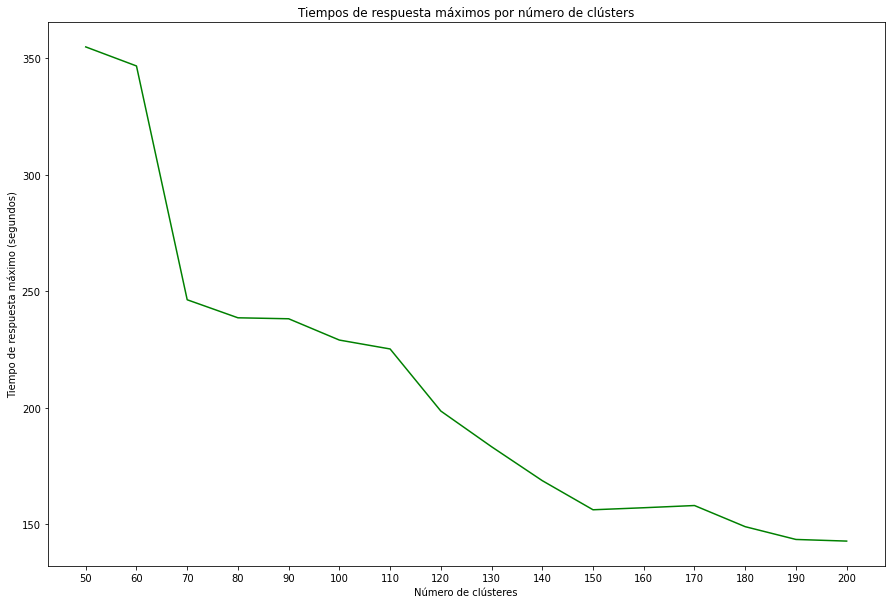

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(list(resultados_tiempos.keys()),list(resultados_tiempos.values()),color='green')
plt.title('Tiempos de respuesta máximos por número de clústers')
plt.xlabel('Número de clústeres')
plt.ylabel('Tiempo de respuesta máximo (segundos)')

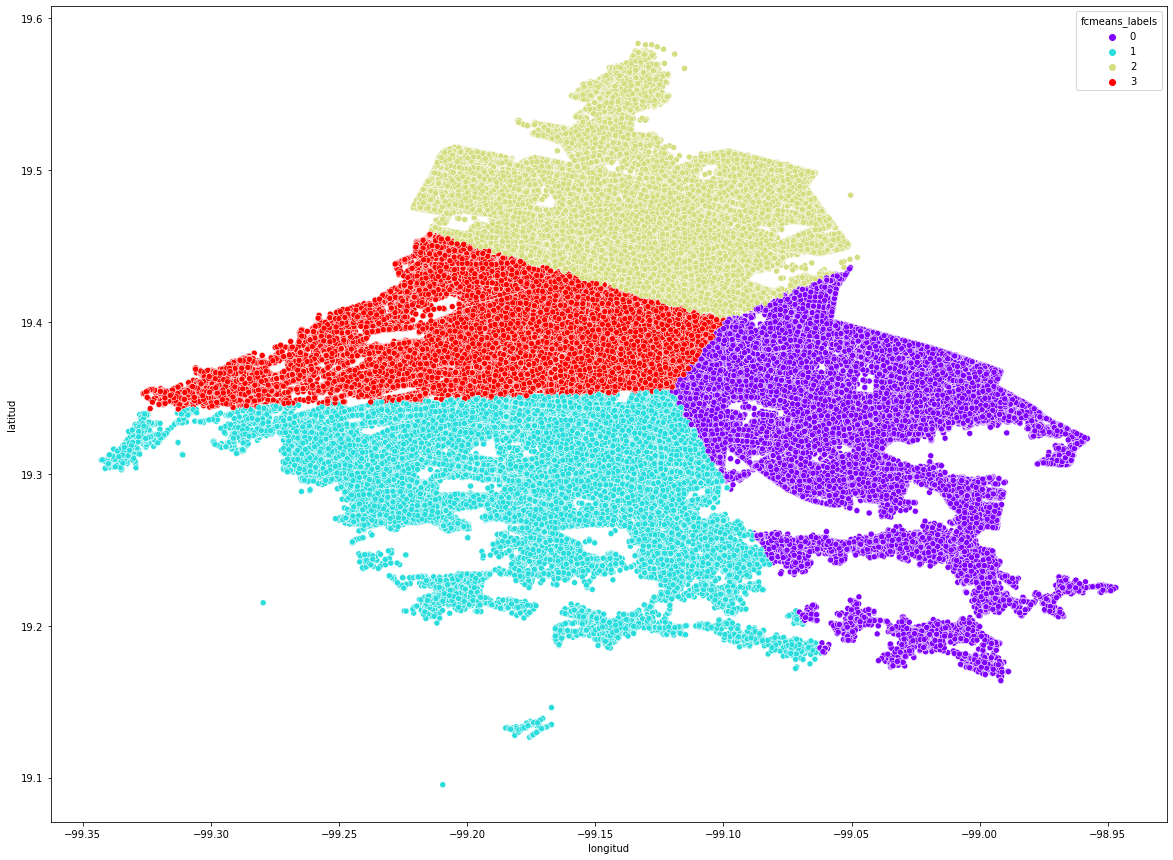

In [36]:
# Imprime representación clusters
#data_delitos_fc4 = pd.read_csv('/content/drive/MyDrive/Proyecto Final IronHack/Primer experimento kmeans/data_delitos_k150.csv')
plt.figure(figsize=(20, 15))
sns.scatterplot(data=data_delitos_fcmeans,x='longitud', y='latitud', hue='fcmeans_labels', palette='rainbow')

In [ ]:
# #Estandariza los valores de latitud y longitud
# X = data_delitos.loc[:,['longitud','latitud']]
# scaler = StandardScaler()
# delitos_scale = scaler.fit_transform(X)
# data_delitos_scale = pd.DataFrame(delitos_scale)
